In [3]:
#Import all the required libraries


!pip install wordcloud
!pip install gtts
!pip install playsound
!pip install seaborn

import seaborn as sns
from collections import Counter



import string
import time
from sklearn.model_selection import train_test_split

#used for creating Progress Meters or Progress Bars
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
#from resources.bleu import Bleu
from tqdm import tqdm
from tqdm import tqdm_notebook, tnrange
from tqdm import tqdm_notebook, tnrange
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.text import Tokenizer


from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from PIL import Image
#from keras.keras_tqdm import TQDMNotebookCallback
print(keras.__version__)
# for arabic text with matplotlib
from bidi import algorithm as bidialg
import arabic_reshaper
!pip install tensorflow 

In [4]:
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display
import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS


In [5]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.config.run_functions_eagerly(True)

In [6]:
from tensorflow.compat.v1 import ConfigProto
config = ConfigProto()
config.gpu_options.allow_growth = True

In [7]:
!pip3 install tqdm

In [9]:
x=42
np.random.seed(x)
tf.random.set_seed(x)

In [10]:
vgg16_weights_path = 'resources/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
images_directory = 'data/Flicker8k_Dataset/'
captions_path = 'data/Flickr8k_text/Flickr8k.token.txt'
arabic_captions_path = 'data/Flickr8k_text/Flickr8k.arabic.full.txt'
train_path = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
dev_path = 'data/Flickr8k_text/Flickr_8k.devImages.txt'
images_features_path = 'resources/Flickr8K_features.pkl'
image_size = (224, 224) # as recommended by vgg16

images_path = []
images_names = []
captions = {} # dictionary where image name (witout extension) is key and list of 3 captions is value
captions_file_text = '' # content of the file that contains images names & their captions
vocabulary = [] # list of all unique words in captions

In [11]:
all_imgs = glob.glob(images_directory + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


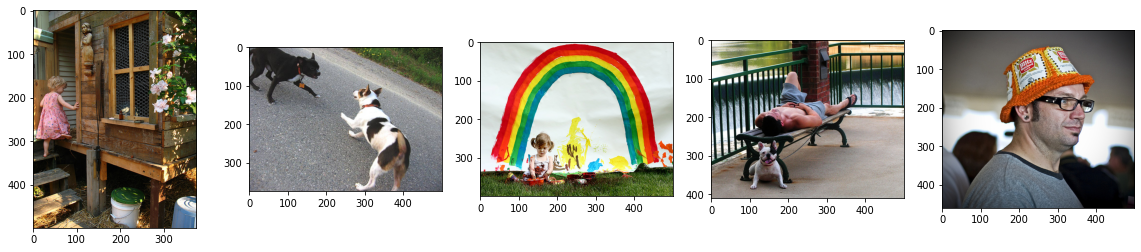

In [12]:
import imageio
#Visualising first 5 images :
Display_Images = all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
for ax, image in zip(axes, Display_Images):
  ax.imshow(imageio.imread(image), cmap=None)


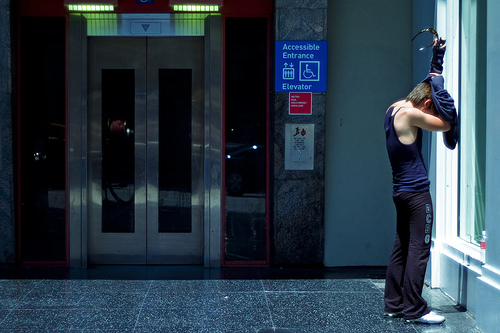

In [13]:
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])# view a random image
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])

In [14]:
def load_file_text(file_path):
    """reads and returns text in captions file"""
    file = open(file_path, 'r', encoding='utf-8')
    all_text = file.read()
    file.close()
    return all_text

def get_captions(file_text):
    """given file content, returns images names and their captions as dictionary"""
    cpts = {}
    #loop through lines
    for line in file_text.split('\n'): # each line contains image name & its caption separated by tab
        #split by tabs
        img_cpt = line.split('\t')
        if len(img_cpt) < 2: continue
        img, cpt = img_cpt
        #remove image extension & index (remove everything befor the dot)
        img_name = img.split('.')[0]
        #add to dictionary
        if img_name not in cpts:
            cpts[img_name] = [cpt]
        else:
            cpts[img_name].append(cpt)
    return cpts

captions_file_text = load_file_text(arabic_captions_path)
captions = get_captions(captions_file_text)
print('Captions #:', len(captions))
print('Caption example:', list(captions.values())[0])

Captions #: 8091
Caption example: ['طفلة صغيرة تتسلق إلى مسرح خشبي', 'طفلة صغيرة تتسلق الدرج إلى منزلها', 'فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية']


In [15]:
def load_image(image_path):
    img = tf.io.read_file(images_directory+image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.efficientnet.preprocess_input(img, data_format=None) 
    return img, image_path

In [16]:
image_path = 'Flickr8k_Dataset/Flicker8k_Dataset'
dir_Flickr_text = 'data/Flickr8k_text/Flickr8k.arabic.full.txt'
arabic_captions_path = 'data/Flickr8k_text/Flickr8k.arabic.full.txt'


file = open(dir_Flickr_text,'r' ,encoding='utf-8' )
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = data.filename.values
img_name_vector = uni_filenames
data.head()


###n 

index                   filename  \
0     0  1000268201_693b08cb0e.jpg   
1     1  1000268201_693b08cb0e.jpg   
2     2  1000268201_693b08cb0e.jpg   
3     0  1001773457_577c3a7d70.jpg   
4     1  1001773457_577c3a7d70.jpg   

                                             caption  
0                     طفلة صغيرة تتسلق إلى مسرح خشبي  
1                  طفلة صغيرة تتسلق الدرج إلى منزلها  
2   فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية  
3  كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما ا...  
4  كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما ...

In [17]:
annotations = data['caption']
len(all_imgs)

8091

In [18]:
#Create the vocabulary & the counter for the captions
vocabulary = [word.lower() for line in annotations for word in line.split()]
val_count = Counter(vocabulary) 
val_count

Counter({'طفلة': 102,
         'صغيرة': 815,
         'تتسلق': 69,
         'إلى': 978,
         'مسرح': 8,
         'خشبي': 112,
         'الدرج': 54,
         'منزلها': 3,
         'فتاة': 1566,
         'في': 11095,
         'ثوب': 158,
         'وردي': 118,
         'تذهب': 3,
         'المقصورة': 1,
         'الخشبية': 11,
         'كلب': 4024,
         'أسود': 1048,
         'وكلب': 187,
         'ثلاثي': 6,
         'الألوان': 35,
         'يلعبان': 333,
         'مع': 2262,
         'بعضهما': 140,
         'البعض': 241,
         'على': 7572,
         'الطريق': 159,
         'أبيض': 1150,
         'ببقع': 3,
         'بنية': 82,
         'يحدقان': 12,
         'الشارع': 355,
         'كلاب': 299,
         'الرصيف': 168,
         'تتحرك': 10,
         'نحو': 168,
         'بعضها': 57,
         'مغطاة': 66,
         'بالطلاء': 6,
         'تجلس': 258,
         'أمام': 862,
         'قوس': 15,
         'قزح': 14,
         'ملون': 30,
         'كبير': 420,
         'لوحة': 44,
     

In [19]:
image_model = tf.keras.applications.EfficientNetB7(include_top=False,
                                                weights='imagenet', input_shape = (299, 299, 3))
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)



In [20]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16,drop_remainder=False)

img_features = {}
for image, image_path in tqdm(image_dataset) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

C:\Users\joood\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
100%|████████████████████████████████████████████████████████████████████████████████| 506/506 [03:31<00:00,  2.34it/s]


In [21]:
batch_feat.shape

TensorShape([100, 2560])

In [22]:
def load_file_text(file_path):
    """reads and returns text in captions file"""
    file = open(file_path, 'r', encoding='utf-8')
    all_text = file.read()
    file.close()
    return all_text

def get_captions(file_text):
    """given file content, returns images names and their captions as dictionary"""
    cpts = {}
    #loop through lines
    for line in file_text.split('\n'): # each line contains image name & its caption separated by tab
        #split by tabs
        img_cpt = line.split('\t')
        if len(img_cpt) < 2: continue
        img, cpt = img_cpt
        #remove image extension & index (remove everything befor the dot)
        img_name = img.split('.')[0]
        #add to dictionary
        if img_name not in cpts:
            cpts[img_name] = [cpt]
        else:
            cpts[img_name].append(cpt)
    return cpts

captions_file_text = load_file_text(arabic_captions_path)
captions = get_captions(captions_file_text)
print('Captions #:', len(captions))
print('Caption example:', list(captions.values())[0])

Captions #: 8091
Caption example: ['طفلة صغيرة تتسلق إلى مسرح خشبي', 'طفلة صغيرة تتسلق الدرج إلى منزلها', 'فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية']


In [23]:
from string import punctuation

def preprocess_captions(cpts):
    """ clean captions to reduce vocabulary size we need to work with:
        - lowercase
        - remove punctuations
        - remove one-character words
        - remove words with numbers
    """
    for img, cpt in cpts.items():
        cpts_ = []
        for c in cpt:
            c = c.lower() #lower case all caption
            c = ''.join([char for char in c if char not in punctuation]) #remove punctuations
            c = ' '.join([w for w in c.split() if len(w)>1 and w.isalpha()]) #remove one-character & numeric words
            cpts_.append(c)
        cpts[img] = cpts_
k = '299178969_5ca1de8e40' #2660480624_45f88b3022
print('before >>', captions[k])
preprocess_captions(captions)
print('captions preprocessed :)')
print('after >>', captions[k])

before >> ['صبي ,يرتدي اللون الأزرق ,  على الأشجار', 'صبي صغير ذو شعر أشقر يبتسم بينما يستلقي على فرع شجرة', 'صبي أشقر يرتدي معطف جينز  ، يجلس على  شجرة']
captions preprocessed :)
after >> ['صبي يرتدي اللون الأزرق على الأشجار', 'صبي صغير ذو شعر أشقر يبتسم بينما يستلقي على فرع شجرة', 'صبي أشقر يرتدي معطف جينز يجلس على شجرة']


In [24]:
from resources1.arabic_preprocessing import Arabic_preprocessing

def preprocess_captions(cpts):
    """ clean captions to get rid of useless textual info & reduce vocabulary size. Preprocessing includes:
        - remove punctuations & diacritics
        - normalize (or standarize) Hamza & Ha2
        - remove repeating characters
        - remove english characters
        - remove one-character words
    """
    process_arab = Arabic_preprocessing()
    for img, cpt in cpts.items():
        processed_captions = [process_arab.preprocess_arabic_text(c) for c in cpt]
        cpts[img] = processed_captions

k = '299178969_5ca1de8e40' #2660480624_45f88b3022
print('before >>', captions[k])
preprocess_captions(captions)
print('captions preprocessed :)')
print('after >>', captions[k])

i = 0
for k,v in captions.items():
    print(v)
    i += 1
    if i == 10: break
        
for k,v in captions.items():
    for cpt in v:
        a = [w for w in cpt.split() if len(w)==1 and w!='و']
        if len(a)>0: print(cpt)
            


before >> ['صبي يرتدي اللون الأزرق على الأشجار', 'صبي صغير ذو شعر أشقر يبتسم بينما يستلقي على فرع شجرة', 'صبي أشقر يرتدي معطف جينز يجلس على شجرة']
captions preprocessed :)
after >> ['صبي يرتدي اللون الازرق علي الاشجار', 'صبي صغير ذو شعر اشقر يبتسم بينما يستلقي علي فرع شجره', 'صبي اشقر يرتدي معطف جينز يجلس علي شجره']
['طفله صغيره تتسلق الي مسرح خشبي', 'طفله صغيره تتسلق الدرج الي منزلها', 'فتاه صغيره في ثوب وردي تذهب الي المقصوره الخشبيه']
['كلب اسود وكلب ثلاثي الالوان يلعبان مع بعضهما البعض علي الطريق', 'كلب اسود وكلب ابيض ببقع بنيه يحدقان في بعضهما البعض في الشارع', 'كلاب علي الرصيف تتحرك نحو بعضها البعض']
['فتاه صغيره مغطاه بالطلاء تجلس امام قوس قزح', 'فتاه صغيره تجلس امام قوس قزح ملون كبير', 'فتاه امام لوحه قوس قزح']
['رجل يجلس علي مقعد بينما يجلس كلبه بجانبه', 'رجل ينام علي مقعد في الخارج مع كلب ابيض واسود يجلس بجانبه', 'رجل بلا قميص يجلس علي مقعد في الحديقه مع كلبه']
['رجل يرتدي قبعه برتقاليه', 'رجل يرتدي قبعه برتقاليه ونظارات', 'الرجل ذو الاذن المثقوبه يرتدي نظارات وقبعه برتقاليه 

In [25]:
def add_start_end_to_captions(cpts):
    """precede each caption with <START> and end each caption with <END>"""
    start, end = '<START>', '<END>'
    #start, end = 'start', 'end'
    for k, v in cpts.items():
        image_captions = [start + ' ' + cpt + ' ' + end for cpt in v]
        cpts[k] = image_captions

add_start_end_to_captions(captions)
print(captions[k])

['<START> رجل يرتدي يتسلق <END>', '<START> رجل يتسلق الصخور في الهواء <END>', '<START> متسلق صخره في قميص احمر <END>']


In [26]:
XX, yy = [], []
train_captions_ar = []
for k,v in captions.items():
    #get output (image caption)
    train_captions_ar.append(v)

In [27]:
train_captions_ar1 = []
for  image_captions in train_captions_ar:
    for image_caption in image_captions:
        train_captions_ar1.append(image_caption)
print(train_captions_ar1)

['<START> طفله صغيره تتسلق الي مسرح خشبي <END>', '<START> طفله صغيره تتسلق الدرج الي منزلها <END>', '<START> فتاه صغيره في ثوب وردي تذهب الي المقصوره الخشبيه <END>', '<START> كلب اسود وكلب ثلاثي الالوان يلعبان مع بعضهما البعض علي الطريق <END>', '<START> كلب اسود وكلب ابيض ببقع بنيه يحدقان في بعضهما البعض في الشارع <END>', '<START> كلاب علي الرصيف تتحرك نحو بعضها البعض <END>', '<START> فتاه صغيره مغطاه بالطلاء تجلس امام قوس قزح <END>', '<START> فتاه صغيره تجلس امام قوس قزح ملون كبير <END>', '<START> فتاه امام لوحه قوس قزح <END>', '<START> رجل يجلس علي مقعد بينما يجلس كلبه بجانبه <END>', '<START> رجل ينام علي مقعد في الخارج مع كلب ابيض واسود يجلس بجانبه <END>', '<START> رجل بلا قميص يجلس علي مقعد في الحديقه مع كلبه <END>', '<START> رجل يرتدي قبعه برتقاليه <END>', '<START> رجل يرتدي قبعه برتقاليه ونظارات <END>', '<START> الرجل ذو الاذن المثقوبه يرتدي نظارات وقبعه برتقاليه اللون <END>', '<START> طفل يلعب علي حبل <END>', '<START> فتاه صغيره تتسلق علي الحبل الاحمر <END>', '<START> طفل صغير ي

In [28]:
train_captions_ar = train_captions_ar1

In [29]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,،-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions_ar)
train_seqs = tokenizer.texts_to_sequences(train_captions_ar)

#add a word for padding 
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions_ar)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)




In [30]:
from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=.1,
                                                                    random_state=42)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)



(21845, 21845, 2428, 2428)

In [192]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [193]:
# Feel free to change these parameters according to your system's configuration

#BATCH_SIZE = 128
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
#features_shape = 1280
features_shape = 2560
attention_features_shape = 49
#units = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

test_num_steps = len(img_name_val) // BATCH_SIZE  

feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [194]:
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [195]:
train_dataset = gen_dataset(img_name_train, cap_train)
test_dataset = gen_dataset(img_name_val, cap_val)

In [196]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 100, 2560)
(64, 26)


In [197]:
'''# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

def create_dataset(img_name, cap):
  dataset = tf.data.Dataset.from_tensor_slices((img_name, cap))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  
  return dataset '''

"# Load the numpy files\ndef map_func(img_name, cap):\n  img_tensor = np.load(img_name.decode('utf-8')+'.npy')\n  return img_tensor, cap\n\ndef create_dataset(img_name, cap):\n  dataset = tf.data.Dataset.from_tensor_slices((img_name, cap))\n\n  # Use map to load the numpy files in parallel\n  dataset = dataset.map(lambda item1, item2: tf.numpy_function(\n            map_func, [item1, item2], [tf.float32, tf.int32]),\n            num_parallel_calls=tf.data.experimental.AUTOTUNE)\n\n  # Shuffle and batch\n  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)\n  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)\n  \n  return dataset "

In [198]:
'''train_dataset = create_dataset(img_name_train, cap_train)
valid_dataset = create_dataset(img_name_val, cap_val)'''

'train_dataset = create_dataset(img_name_train, cap_train)\nvalid_dataset = create_dataset(img_name_val, cap_val)'

In [199]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [200]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [201]:
encoder=Encoder(embedding_dim)

In [202]:
from keras.utils.vis_utils import plot_model


In [203]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

In [204]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        #self.no = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = self.dropout(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.dropout(output)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        output = self.dropout(output)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [205]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [206]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 100, 256)
Predcitions shape from Decoder: (64, 10436)
Attention weights shape from Decoder: (64, 100, 1)


In [207]:
'''def get_encoder(embedding_dim):
    input = tf.keras.layers.Input((attention_features_shape, features_shape))
    # shape after fc == (batch_size, 49, embedding_dim)
    output = tf.keras.layers.Dense(embedding_dim, activation = "relu")(input)
    
    return tf.keras.models.Model(inputs = input, outputs = output)
  
  
def get_decoder(embedding_dim, units, vocab_size):
    gru = tf.keras.layers.GRU(units,
                   return_sequences=True,
                   return_state=True,
                   recurrent_initializer='glorot_uniform')

  
    #define the inputs to the decoder
    enc_output = tf.keras.layers.Input((attention_features_shape, embedding_dim))
    enc_hidden = tf.keras.layers.Input((embedding_dim,))
    dec_input = tf.keras.layers.Input((1,))
    
    hidden_with_time_axis = tf.keras.layers.Reshape((1, units))(enc_hidden)

    # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
    W1 = tf.keras.layers.Dense(units)
    W2 = tf.keras.layers.Dense(units)
    V  = tf.keras.layers.Dense(1)
    
    attention_weights = V(tf.keras.layers.Activation(activation = "tanh")(tf.keras.layers.Add()([W1(enc_output), W2(hidden_with_time_axis)])))
    attention_weights = tf.keras.layers.Activation(activation = "softmax")(tf.keras.layers.Permute((2, 1))(attention_weights))
    attention_weights = tf.keras.layers.Permute((2, 1))(attention_weights)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = tf.keras.layers.Multiply()([attention_weights, enc_output])
    
    # reshape the context_vector to concatneate with the output of the first input
    context_vector = tf.keras.layers.Permute((2, 1))(context_vector)
    context_vector = tf.keras.layers.Dense(1)(context_vector)
    context_vector = tf.keras.layers.Permute((2, 1))(context_vector)
    
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(dec_input)
    x = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=42)(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.keras.layers.Concatenate(axis = -1)([context_vector, x])
    # passing the concatenated vector to the GRU
    output, state = gru(x)
    
    output = tf.keras.layers.Dense(units)(output)
     output = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=42)(output)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.keras.layers.Reshape((output.shape[2],))(output)

    # output shape == (batch_size * 1, vocab)
    x = tf.keras.layers.Dense(vocab_size)(output)

    return tf.keras.models.Model(inputs = [dec_input, enc_hidden, enc_output], outputs = [x, state])'''

'def get_encoder(embedding_dim):\n    input = tf.keras.layers.Input((attention_features_shape, features_shape))\n    # shape after fc == (batch_size, 49, embedding_dim)\n    output = tf.keras.layers.Dense(embedding_dim, activation = "relu")(input)\n    \n    return tf.keras.models.Model(inputs = input, outputs = output)\n  \n  \ndef get_decoder(embedding_dim, units, vocab_size):\n    gru = tf.keras.layers.GRU(units,\n                   return_sequences=True,\n                   return_state=True,\n                   recurrent_initializer=\'glorot_uniform\')\n\n  \n    #define the inputs to the decoder\n    enc_output = tf.keras.layers.Input((attention_features_shape, embedding_dim))\n    enc_hidden = tf.keras.layers.Input((embedding_dim,))\n    dec_input = tf.keras.layers.Input((1,))\n    \n    hidden_with_time_axis = tf.keras.layers.Reshape((1, units))(enc_hidden)\n\n    # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V\n    W1 = tf.keras.layers.Dense(

In [208]:
optimizer = tf.keras.optimizers.Adam(0.0001)  #define the optimizer learning_rate = 0.001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [209]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [210]:
checkpoint_path = "DecModel/checkpoint2"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [211]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [212]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss


In [213]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    encoder_op = encoder(img_tensor)
    for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch                   
    return loss, avg_loss

In [214]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss = total_loss + t_loss
    avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [215]:
keras.backend.clear_session()
loss_plot = []
test_loss_plot = []
EPOCHS = 30
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss=total_loss / num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.955, & test loss is 1.869
Time taken for 1 epoch 257.4610514640808 sec

Test loss has been reduced from 100.000 to 1.869



  3%|██▋                                                                             | 1/30 [04:17<2:04:38, 257.87s/it]

For epoch: 2, the train loss is 1.698, & test loss is 1.654
Time taken for 1 epoch 216.1305284500122 sec

Test loss has been reduced from 1.869 to 1.654



  7%|█████▎                                                                          | 2/30 [07:54<1:54:34, 245.50s/it]

For epoch: 3, the train loss is 1.506, & test loss is 1.514
Time taken for 1 epoch 184.5222511291504 sec

Test loss has been reduced from 1.654 to 1.514



 10%|████████                                                                        | 3/30 [10:59<1:42:20, 227.42s/it]

For epoch: 4, the train loss is 1.403, & test loss is 1.447
Time taken for 1 epoch 189.26379776000977 sec

Test loss has been reduced from 1.514 to 1.447



 13%|██████████▋                                                                     | 4/30 [14:09<1:33:37, 216.07s/it]

For epoch: 5, the train loss is 1.334, & test loss is 1.397
Time taken for 1 epoch 217.26909923553467 sec

Test loss has been reduced from 1.447 to 1.397



 17%|█████████████▎                                                                  | 5/30 [17:46<1:30:13, 216.52s/it]

For epoch: 6, the train loss is 1.279, & test loss is 1.360
Time taken for 1 epoch 218.54244136810303 sec

Test loss has been reduced from 1.397 to 1.360



 20%|████████████████                                                                | 6/30 [21:25<1:26:53, 217.22s/it]

For epoch: 7, the train loss is 1.232, & test loss is 1.330
Time taken for 1 epoch 215.29954028129578 sec

Test loss has been reduced from 1.360 to 1.330



 23%|██████████████████▋                                                             | 7/30 [25:01<1:23:04, 216.73s/it]

For epoch: 8, the train loss is 1.190, & test loss is 1.304
Time taken for 1 epoch 215.53640389442444 sec

Test loss has been reduced from 1.330 to 1.304



 27%|█████████████████████▎                                                          | 8/30 [28:37<1:19:22, 216.47s/it]

For epoch: 9, the train loss is 1.150, & test loss is 1.281
Time taken for 1 epoch 193.37262773513794 sec

Test loss has been reduced from 1.304 to 1.281



 30%|████████████████████████                                                        | 9/30 [31:50<1:13:22, 209.64s/it]

For epoch: 10, the train loss is 1.117, & test loss is 1.263
Time taken for 1 epoch 188.93171000480652 sec

Test loss has been reduced from 1.281 to 1.263



 33%|██████████████████████████▎                                                    | 10/30 [35:00<1:07:50, 203.52s/it]

For epoch: 11, the train loss is 1.084, & test loss is 1.249
Time taken for 1 epoch 173.2363681793213 sec

Test loss has been reduced from 1.263 to 1.249



 37%|████████████████████████████▉                                                  | 11/30 [37:53<1:01:35, 194.52s/it]

For epoch: 12, the train loss is 1.056, & test loss is 1.239
Time taken for 1 epoch 173.38586258888245 sec

Test loss has been reduced from 1.249 to 1.239



 40%|████████████████████████████████▍                                                | 12/30 [40:47<56:28, 188.26s/it]

For epoch: 13, the train loss is 1.030, & test loss is 1.231
Time taken for 1 epoch 172.67742323875427 sec

Test loss has been reduced from 1.239 to 1.231



 43%|███████████████████████████████████                                              | 13/30 [43:40<52:02, 183.68s/it]

For epoch: 14, the train loss is 1.003, & test loss is 1.222
Time taken for 1 epoch 172.9261875152588 sec

Test loss has been reduced from 1.231 to 1.222



 47%|█████████████████████████████████████▊                                           | 14/30 [46:33<48:08, 180.55s/it]

For epoch: 15, the train loss is 0.980, & test loss is 1.217
Time taken for 1 epoch 183.2328073978424 sec

Test loss has been reduced from 1.222 to 1.217



 50%|████████████████████████████████████████▌                                        | 15/30 [49:37<45:21, 181.45s/it]

For epoch: 16, the train loss is 0.958, & test loss is 1.211
Time taken for 1 epoch 184.08975911140442 sec

Test loss has been reduced from 1.217 to 1.211



 53%|███████████████████████████████████████████▏                                     | 16/30 [52:41<42:32, 182.33s/it]

For epoch: 17, the train loss is 0.935, & test loss is 1.211
Time taken for 1 epoch 184.2938051223755 sec




 57%|█████████████████████████████████████████████▉                                   | 17/30 [55:45<39:38, 182.93s/it]

For epoch: 18, the train loss is 0.914, & test loss is 1.210
Time taken for 1 epoch 182.70233798027039 sec

Test loss has been reduced from 1.211 to 1.210



 60%|████████████████████████████████████████████████▌                                | 18/30 [58:48<36:35, 182.95s/it]

For epoch: 19, the train loss is 0.894, & test loss is 1.207
Time taken for 1 epoch 187.4985237121582 sec

Test loss has been reduced from 1.210 to 1.207



 63%|██████████████████████████████████████████████████                             | 19/30 [1:01:56<33:48, 184.40s/it]

For epoch: 20, the train loss is 0.875, & test loss is 1.205
Time taken for 1 epoch 174.37338256835938 sec

Test loss has been reduced from 1.207 to 1.205



 67%|████████████████████████████████████████████████████▋                          | 20/30 [1:04:51<30:14, 181.48s/it]

For epoch: 21, the train loss is 0.856, & test loss is 1.206
Time taken for 1 epoch 174.13172364234924 sec




 70%|███████████████████████████████████████████████████████▎                       | 21/30 [1:07:45<26:53, 179.28s/it]

For epoch: 22, the train loss is 0.837, & test loss is 1.212
Time taken for 1 epoch 174.3864197731018 sec




 73%|█████████████████████████████████████████████████████████▉                     | 22/30 [1:10:39<23:42, 177.81s/it]

For epoch: 23, the train loss is 0.819, & test loss is 1.209
Time taken for 1 epoch 174.5222442150116 sec




 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [1:13:34<20:37, 176.83s/it]

For epoch: 24, the train loss is 0.802, & test loss is 1.214
Time taken for 1 epoch 179.95939087867737 sec




 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [1:16:34<17:46, 177.77s/it]

For epoch: 25, the train loss is 0.786, & test loss is 1.218
Time taken for 1 epoch 182.31440949440002 sec




 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [1:19:36<14:55, 179.13s/it]

For epoch: 26, the train loss is 0.770, & test loss is 1.222
Time taken for 1 epoch 182.94435834884644 sec




 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [1:22:39<12:01, 180.28s/it]

For epoch: 27, the train loss is 0.757, & test loss is 1.228
Time taken for 1 epoch 181.35924220085144 sec




 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [1:25:40<09:01, 180.61s/it]

For epoch: 28, the train loss is 0.746, & test loss is 1.229
Time taken for 1 epoch 181.56019830703735 sec




 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [1:28:42<06:01, 180.89s/it]

For epoch: 29, the train loss is 0.726, & test loss is 1.235
Time taken for 1 epoch 180.57064843177795 sec




 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [1:31:43<03:00, 180.80s/it]

For epoch: 30, the train loss is 0.711, & test loss is 1.247
Time taken for 1 epoch 181.09318327903748 sec




100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:34:44<00:00, 180.89s/it]


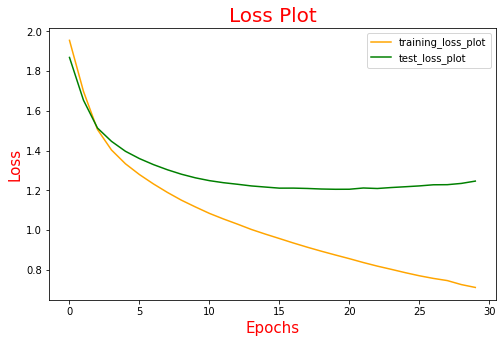

In [216]:
from matplotlib.pyplot import figure
figure(figsize=(8, 5))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()


In [239]:
test_loss_plot_eff = test_loss_plot
%store test_loss_plot_eff

Stored 'test_loss_plot_eff' (list)


In [217]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [218]:
def plot_attention_map (caption, weights, image) :

  fig = plt.figure(figsize = (20, 20))
  temp_img = np.array(Image.open(images_directory+image))

  cap_len = len(caption)
  for cap in range(cap_len) :
    #weights_img = np.reshape(weights[cap], (9,9))
    weights_img = np.array(Image.fromarray(weights[cap]).resize((224,224), Image.LANCZOS))

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap], fontsize = 14, color = 'red')

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [219]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [220]:
image_test = img_name_val.copy()

In [221]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = cap_val.copy()
    rid = np.random.randint(0, random)
    test_image = image_test[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)


    return test_image
    


BLEU score: 100.0
Real Caption: كلب اسود يقفز في الثلج
Prediction Caption: كلب اسود يقفز في الثلج


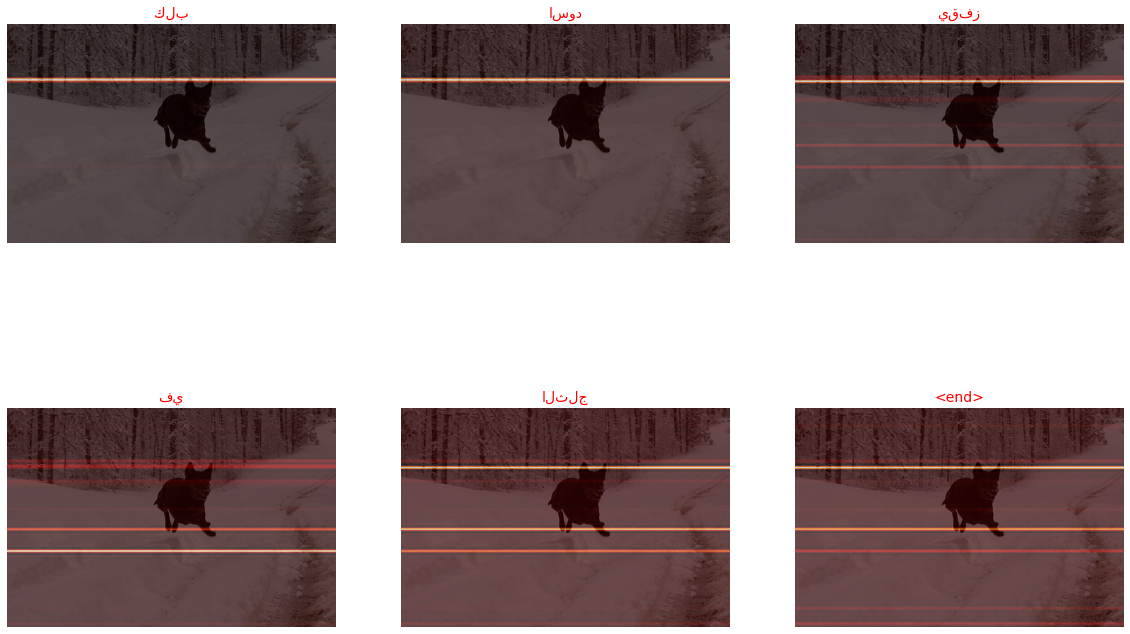

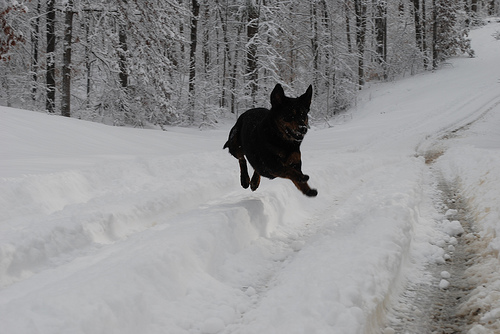

In [222]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(images_directory+test_image)

In [223]:
counter=0;
captions_test = {}
caption = []
for x in img_name_val:
    res=x.rsplit('/',1)
    list_loc= data.index[data['filename']==res[0]].tolist()
    for s in list_loc:
        caption.append(data['caption'].iloc[s])
    captions_test[res[0]]=caption
    caption=[]
    




In [224]:
x=img_name_val[0]
res=x.rsplit('/',1)
print(res[0])
s= data['filename'][0]
print(s)

3158327361_6f1a518228.jpg
1000268201_693b08cb0e.jpg


In [225]:
img_cap_val_real22 = []
img_cap_val_pred22 = []
counter = 0
for image in captions_test :
    real_caption = captions_test[image]
    
    result, attention_plot, pred_test = evaluate(image)
    
    #remove "<unk>" in result
    for c in result:
        if c=="<unk>":
            result.remove(c)

    for c in real_caption:
        if c=="<unk>":
            real_caption.remove(c)
    
    #remove <end> from result        
    result_join = ' '.join(result)
    result_final = result_join.rsplit(' ', 1)[0]
    img_cap_val_real22.append(real_caption)
    img_cap_val_pred22.append(result_final)
    counter =  counter + 1
    print(counter)
   

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [240]:
list_of_references5 = list()
list_of_references55 = []
hypotheses5 = list()
for images_captions1 in img_cap_val_real22:
    list_of_references55=[d.split() for d in images_captions1]
    list_of_references5.append(list_of_references55)
    list_of_references55=[]
    
for cpt in img_cap_val_pred22:
    for i in cpt.split():
        if i=="<unk>":
            cpt=cpt.replace(i,'')
    hypotheses5.append(cpt.split())
    
print('BLEU-1: %f' % corpus_bleu(list_of_references5, hypotheses5, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(list_of_references5, hypotheses5, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(list_of_references5, hypotheses5, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4: %f' % corpus_bleu(list_of_references5, hypotheses5, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.390540
BLEU-2: 0.242575
BLEU-3: 0.145625
BLEU-4: 0.083287


In [227]:
def pred_caption(random, autoplay=False, weights=(1.0, 0, 0, 0)) :

    cap_test_data = cap_val.copy()
    rid = random
    test_image = image_test[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)


    return test_image
    

BLEU score: 10.735389901075512
Real Caption: طفل صغير يرتدي احمر اللون يتارجح علي ارجوحه زهريه
Prediction Caption: صبي صغير في قميص اخضر في الملعب


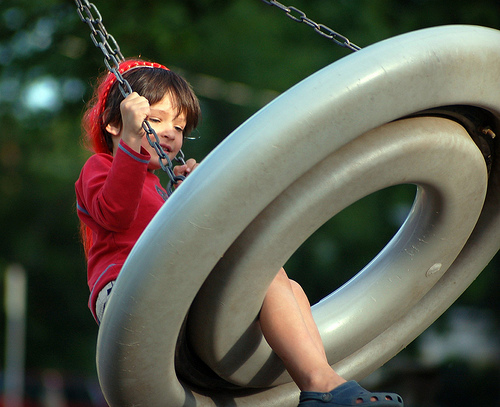

In [228]:
test_image = pred_caption(25)
Image.open(images_directory+test_image)

BLEU score: 11.111111111111109
Real Caption: شخص يركب دراجه ويرتدي خوذه عبر منطقه مشجره
Prediction Caption: رجل يرتدي ستره سوداء وخوذه علي دراجه علي تله


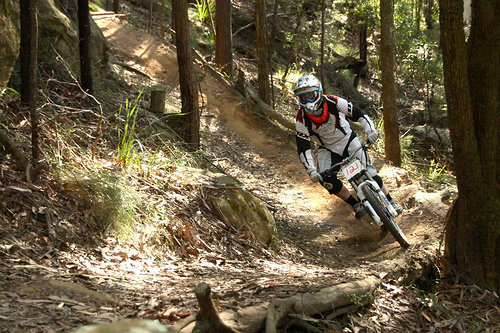

In [248]:
test_image = pred_caption(2114)
Image.open(images_directory+test_image)

BLEU score: 16.666666666666668
Real Caption: الصبي يتزلج علي الدرابزين
Prediction Caption: صبي يقوم بخدعه علي سكه حديد


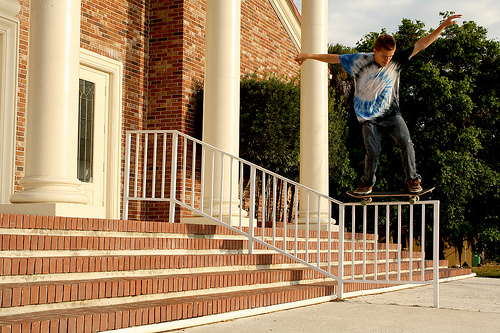

In [229]:
test_image = pred_caption(22)
Image.open(images_directory+test_image)

BLEU score: 16.666666666666668
Real Caption: رجل يقف فوق جرف صخري فوق الماء
Prediction Caption: رجل بلا قميص ابيض يقف علي حافه الصخور المطله علي حافه المحيط


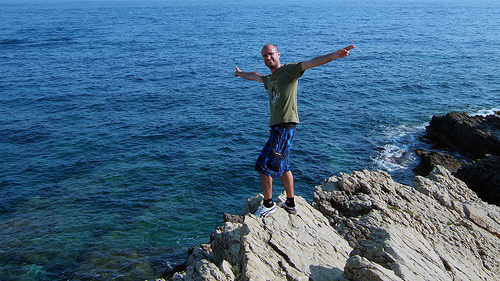

In [230]:
test_image = pred_caption(641)
Image.open(images_directory+test_image)

BLEU score: 40.0
Real Caption: كلب يركض من خلال الفناء
Prediction Caption: كلب اسود يركض عبر العشب


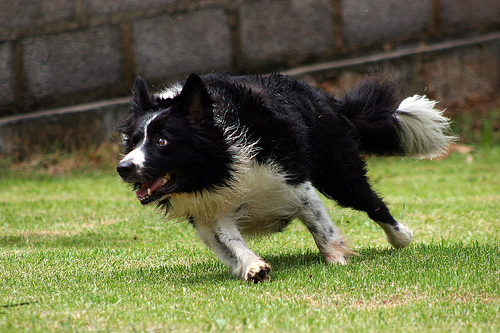

In [231]:
test_image = pred_caption(411)
Image.open(images_directory+test_image)

BLEU score: 49.12384518467891
Real Caption: رجل يركب دراجه علي جانب التل
Prediction Caption: رجل يركب دراجه في طريق


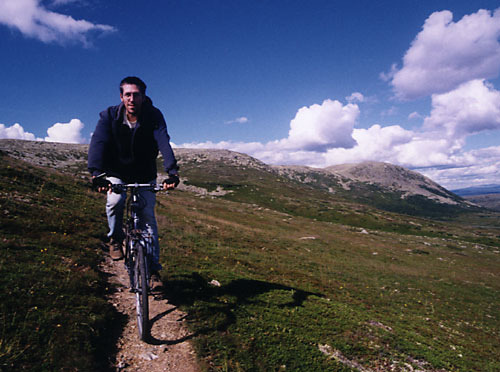

In [237]:
test_image = pred_caption(2049)
Image.open(images_directory+test_image)